In [1]:
%%time

#Modded from qutip to allow parallelism
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator

def floquet_modes_mod(H, T, args=None, parallel=False, sort=False, U=None):
    """
    Calculate the initial Floquet modes Phi_alpha(0) for a driven system with
    period T.

    Returns a list of :class:`qutip.qobj` instances representing the Floquet
    modes and a list of corresponding quasienergies, sorted by increasing
    quasienergy in the interval [-pi/T, pi/T]. The optional parameter `sort`
    decides if the output is to be sorted in increasing quasienergies or not.

    Parameters
    ----------

    H : :class:`qutip.qobj`
        system Hamiltonian, time-dependent with period `T`

    args : dictionary
        dictionary with variables required to evaluate H

    T : float
        The period of the time-dependence of the hamiltonian. The default value
        'None' indicates that the 'tlist' spans a single period of the driving.

    U : :class:`qutip.qobj`
        The propagator for the time-dependent Hamiltonian with period `T`.
        If U is `None` (default), it will be calculated from the Hamiltonian
        `H` using :func:`qutip.propagator.propagator`.

    Returns
    -------

    output : list of kets, list of quasi energies

        Two lists: the Floquet modes as kets and the quasi energies.

    """
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, parallel=parallel, progressbar=True, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

CPU times: user 766 ms, sys: 168 ms, total: 933 ms
Wall time: 1.07 s


/usr/local/anaconda3/anaconda3/envs/hpc/lib/python3.11/site-packages/qutip/configrc.py:294: UserWarning: Invalid qutip config variable in qutiprc: num_cpus
  warnings.warn("Invalid qutip config variable in qutiprc: "


# Introduction

Dynamical Freezing (DMF) is a phenomenon whereby periodically driven Many Body Systems are prevented from thermalizing to infinite temperature due to a dynamical hysteresis that prevents observables from reaching their diagonal averaged values.

DMF can, under certain resonance conditions in the drive parameters, cause the response to ‘freeze’ completely to its initial value for all times. This has been demonstrated (via the Jordan-Wigner Transformation) in the driven TFIM with nearest neighbour interactions, and is shown to be protected when translational invariance is explicitly broken (say, by disorder). 

We have suspected that this is also protected against the loss of other symmetries, for example, in long range systems where JW transformation produces nonlocalities. To prove this, we introduce a long-range power law dependence in the TFIM, where the exchange $J_{ij}\sim 1/|i-j|^\beta$. Here, for $\beta=\infty$, we recover the short range TFIM and freezing at resonant drive parameters. When $\beta=0$, taking $N\rightarrow\infty$ allows us to describe the exact dynamics by the periodically driven Lipkin-Meshkov-Glick (LMG) model, which we have solved numerically to obtain a similar kind of DMF and ‘freezing’ as the$\beta=\infty$ case.

Now, we compare the degree of localization of the quasi-stationary Floquet modes in both cases. In order to do so, we look at the Inverse Participation Ratios (IPR) of the modes in the representation given by the eigenstates of the symmetry-breaking field. 

What we're seeing is that there appears to be a high degree of localization in the TFIM case, as consistent with analytical treatments using the Rotated Wave Approximation (RWA), where only the slowest rotating terms in the Fourier expansion of the Hamiltonian in a frame co-rotating with the symmtry-breaking driving field are retained. However, this localization remains qualitatively strong even at lower drive frequencies where RWA breaks down.

In the driven LMG model, the localization is similar to the Ising model for high frequencies, but breaks down substantively at lower frequencies due to the onset of dynamical chaos in the thermodynamic limit. Thus, a change of phase should occur from a thermal state to an athermal one if the drive frequency is varied adiabatically.

## Background
A generic interacting quantum many body system, if driven time-periodically for a sufficiently long time, is expected to follow a dynamical route to thermalization at infinite temperature. This can be demonstrated by the Eigenstate Thermalization Hypothesis (ETH), where long-time averages of observables, resolved in the basis of stationary states, approach the average predicted by the microcanonical ensemble. 

For instance, if the stationary states are expressed by $|e_i\rangle$, with corresponding eigenvalues $e_i$ of Hamiltonian $H$, then the time-evolution of an observable $O$ on a closed isolated quantum system starting from $|\psi_0\rangle$ at $t=0$ is
\begin{align*}
\langle O (t) \rangle &= \langle e^{iHt}Oe^{-iHt}\rangle\\
                      &= \sum_{ij}e^{-i\big(e_i-e_j\big)t} O_{ij} \langle\psi_0|e_i\rangle \langle e_j|\psi_0\rangle.
\end{align*}
The time-average of this expectation, averaged over very long times and non-degenerate $e_i$, is expected to be
\begin{align*}
\overline{\langle O (t) \rangle} &= \sum_{ij}\overline{e^{-i\big(e_i-e_j\big)t}}O_{ij} \langle\psi_0|e_i\rangle \langle e_j|\psi_0\rangle\\
 &= \sum_{ij}\delta_{ij}O_{ij} \langle\psi_0|e_i\rangle \langle e_j|\psi_0\rangle\\
 &=\sum_i O_{ii}\bigg\vert \langle e_i\vert\psi_0\rangle \bigg\vert^2,
\end{align*}
Thus, after a long time, $\overline{O}$ reaches a diagonal average that, under the conditions of ETH, should thermalize. However, a high degree of degeneracy in the eigenvalues $e_i$ will prevent some of the $\overline{e^{-i\big(e_i-e_j\big)t}}$-terms from reaching $\delta_{ij}$. In the extreme case when all the eigenvalues are equal, the diagonal average values are dynamically suppressed, leading to **Dynamical Many Body Localization** or **Many Body Freezing**. We want to look at localization of Floquet eigenstates in this regime.

# Investigation of IPR in the Floquet Dynamics of Many Body Systems

We're trying to look at localization/freezing in rapidly driven time-periodic systems. Specifically, we want to check whether freezing exists in long raange spin systems in the manner seen for short range systems. We start by defining the *Inverse Participation Ratio* (IPR) for a wavefunction $\psi(x)$ as 
\begin{equation*}
\phi_{IPR}\equiv \int dx\;\vert\psi(x)\vert^4
\end{equation*}

More generally, the IPR of a state $|\phi\rangle$ in a representation given by complete orthonormal basis $|m\rangle$ is $\phi_{IPR} = \sum_m\vert\langle m \vert\phi\rangle\vert^4$.

In the context of localization, the IPR is useful. The smallest value of the IPR corresponds to a fully delocalized state, $\psi(x)=1/\sqrt{N}$ for a system of size $N$, where the IPR yields $\sum_x |\psi(x)|^4=N/(N^{1/2})^4=1/N$. Values of the IPR close to 1 correspond to localized states. For a periodically driven system, we look at the IPR of the Floquet modes at $t=T$, where $t=2\pi/\omega$ for drive frequency $\omega$.

## Transverse-Field Ising model.
First, consider the well-known Hamiltonian of the driven Transverse Field Ising model of $N$ spins:
\begin{align*}
 H(t) &= H_0 + \left(h_0 + h\cos{\omega t}\right) H_1\\
H_0 &= -\frac{1}{2}\sum_{i} \sigma^x_i \sigma^x_{i+1}\\
H_1 &= -\frac{1}{2}\sum_n^N \sigma^z_{n}
\end{align*}

The TFIM model can be readily transformed into a Bogoliubov-type fermionic system via the Jordan-Wigner transformation. This yields an effective Hamiltonian

\begin{equation*}
\mathcal{H}(t)=\sum_{{k, -k}} \psi_{{k}}^{\dagger}\left(\begin{array}{cc}
h_{z}(t)+f_{{k}} & \Delta_{{k}} \\
\Delta_{{k}}^{*} & -h_{z}(t)-f_{{k}}
\end{array}\right) \psi_{{k}},
\end{equation*}

where $h_z(t) = h_0 + h\cos{\omega t}$, $\psi_k = (c_{-k}, c^\dagger_k)^T$, with $f_k = J\cos{k}$, $\Delta_k = J\sin{k}$. We can rewrite

\begin{equation*}
H(t) = \sum_{k,-k} \psi^\dagger_k
\Big[\sigma_z f_k + \sigma_x \Delta_k + \sigma_z h_z(t)\Big]\psi_k
\end{equation*}

For a particular $k,-k$ pair, let us define the undriven part $H_0(k) = \sigma_z f_k + \sigma_x \Delta_k$ and $H_1 = \sigma_z$, yielding 
$H_k(t) = H_0(k) + h\cos{\omega t}\; H_1$. Now, we transform to the rotated frame via the unitary transformation operator $U = e^{i\int H_d d t} = exp \Big[\frac{i h}{\omega}\sin{\omega t}\Big]\sigma_z$. This yields
\begin{align*}
H^\prime_k(t) &= U^\dagger H_0(k) U \\
&=e^{-i\frac{h}{\omega}\sin{\omega t}\sigma_z} H_0(k) e^{i\frac{h}{\omega}\sin{\omega t}\sigma_z}\\
\end{align*}


If we define defined $\eta=2h/\omega$, then
\begin{align*}
H^\prime_k(t) &= \begin{pmatrix}e^{-i\frac12\eta\sin{\omega t}}&0\\0&e^{i\frac12\eta\sin{\omega t}}\end{pmatrix} \begin{pmatrix}f_k&\Delta_k\\\Delta_k &-f_k\end{pmatrix}\begin{pmatrix}e^{i\frac12\eta\sin{\omega t}}&0\\0&e^{-i\frac12\eta\sin{\omega t}}\end{pmatrix}\\
&= \begin{pmatrix}f_k&e^{i\eta\sin{\omega t}}\Delta_k\\e^{-i\eta\sin{\omega t}}\Delta_k&-f_k\end{pmatrix}\\
&=  \sigma^z f_k + 2\sigma^x \Delta_k \sum_{n\geq 0} J_{2n}(\eta)\cos{\big(2n\omega t\big)} - 2\sigma^y\Delta_k \sum_{n\geq 0} J_{2n+1}(\eta)\sin{\bigg[\big(2n+1\big)\omega t\bigg]}
\end{align*}
Here, in the last step, have used the Jacobi-Anger formula $e^{i \eta \sin{\omega t}} \equiv \sum_{n=-\infty}^{\infty} J_n(\eta)\, e^{i n \omega t}$. Now, for large $\omega \gg f_k$, the RWA approximation allows us to replace $H^\prime_k(t)$ by it's long-time average, leaving behind only the non-oscillating modes in the expansion above, an effective Hamiltonian [1]
\begin{equation*}
H^{(RWA)}_k=f_k \sigma^z + 2 J_0(\eta)\Delta_k\sigma^x.
\end{equation*}
Clearly, if we adjust drive parameters such that $\eta$ lies on a root of $J_0(\eta)$, then $\sigma^z$ becomes a conserved quantity. A particular Floquet mode of the Hamiltonian can, in general, be written as $|\phi\rangle = \prod_{k,-k}|\phi^n_k\rangle$. In the RWA limit and in the regime where $J_0(\eta)$ vanishes, $|\phi^n_k\rangle$ has values of $|0\rangle, |k,-k\rangle$ for two values of $n=0,1$ respectively.

We define the reduced IPR of $|\phi^n_k\rangle\; \forall k$ to be
\begin{equation*}
\phi^{(n)}_{IPR}(k) = \left\vert \langle 0 |\phi^n_k\rangle  \right\vert^4 + \left\vert \langle +k, -k |\phi^n_k\rangle  \right\vert^4,
\end{equation*}
where $n=0,1$. In the RWA limit, when $J_0(eta)$ vanishes, this quantity is unity, indicating low participation and high degree of localization.


The code cell below plots $\phi^n_{IPR}(k)$ for the full exact dynamics, with different drive amplitudes $h$, and $\omega = 90$ fixed.



## References:

[1] Das, A. arXiv:0904.2172 (2009)

In [3]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes
from scipy.special import j0

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_floquet_isingfermion(k, args, **kwargs):
    
    sx = sigmax()
    sz = sigmaz()
    
    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    
    H = [H0,[H1,drive]]    
    T = 2 * np.pi/args['omega']

    return floquet_modes(H, T, args, **kwargs)

def get_iprvals_exact(k, params, **kwargs):
    f_states, f_energies = get_floquet_isingfermion(k, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 37 µs, sys: 4 µs, total: 41 µs
Wall time: 60.8 µs


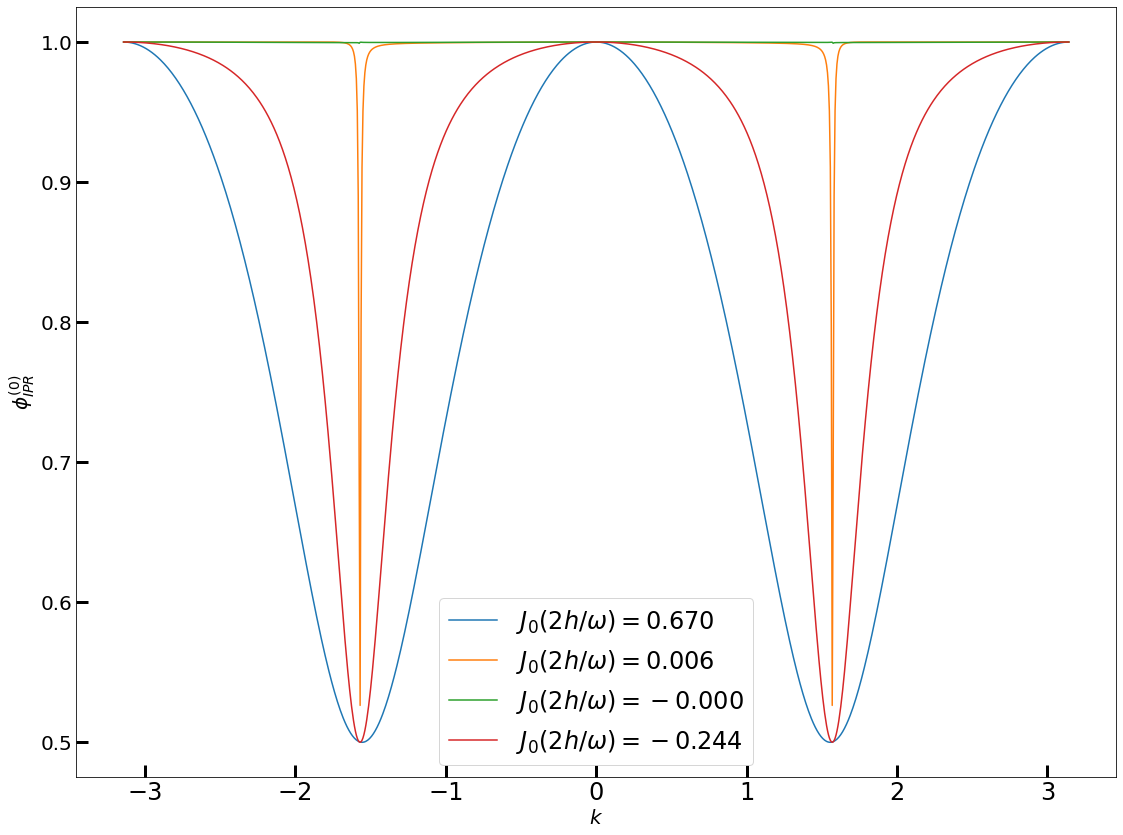

CPU times: user 11.2 s, sys: 3.97 ms, total: 11.2 s
Wall time: 11.2 s


In [14]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm
import traceback

plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2
hmed = 0.995 * omega * freezing_pts/2
hmax = 1.25 * omega * max_pts/2
hfin = 0.5 * omega * freezing_pts/2


delta = 1e-4
fbz = np.linspace(-np.pi+delta, np.pi-delta, 1000)

for h in np.sort([hfrz[0], hmed[0], hmax[0], hfin[0]]):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    iprvals_exact = np.array([get_iprvals_exact(k, params, sort=True) for k in fbz])
    plt.plot(fbz, iprvals_exact[:,0], label=fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")

plt.ylabel(f'$\phi^{{({{0}})}}_{{IPR}}$')
plt.xlabel(r'$k$')
plt.legend()

plt.show()

In [4]:
%%time
import numpy as np
from tqdm import tqdm
from scipy.special import jn_zeros

freezing_points = jn_zeros(0,3)

#
# set up the calculation
#
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2

delta = 1e-7
fbz = np.linspace(-np.pi+delta, np.pi-delta, 100)
hvals = np.linspace(0.0, 7*omega, 200)
#include freezing points
hvals = np.sort(np.append(hvals, hfrz))

iprmat = np.empty([len(hvals), len(fbz)])
for x, h in tqdm(enumerate(hvals)):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    iprvals_exact = np.array([get_iprvals_exact(k, params, sort=True) for k in fbz])
    iprmat[x,:] = iprvals_exact[:,0]

204it [02:50,  1.20it/s]

CPU times: user 2min 50s, sys: 372 ms, total: 2min 50s
Wall time: 2min 50s


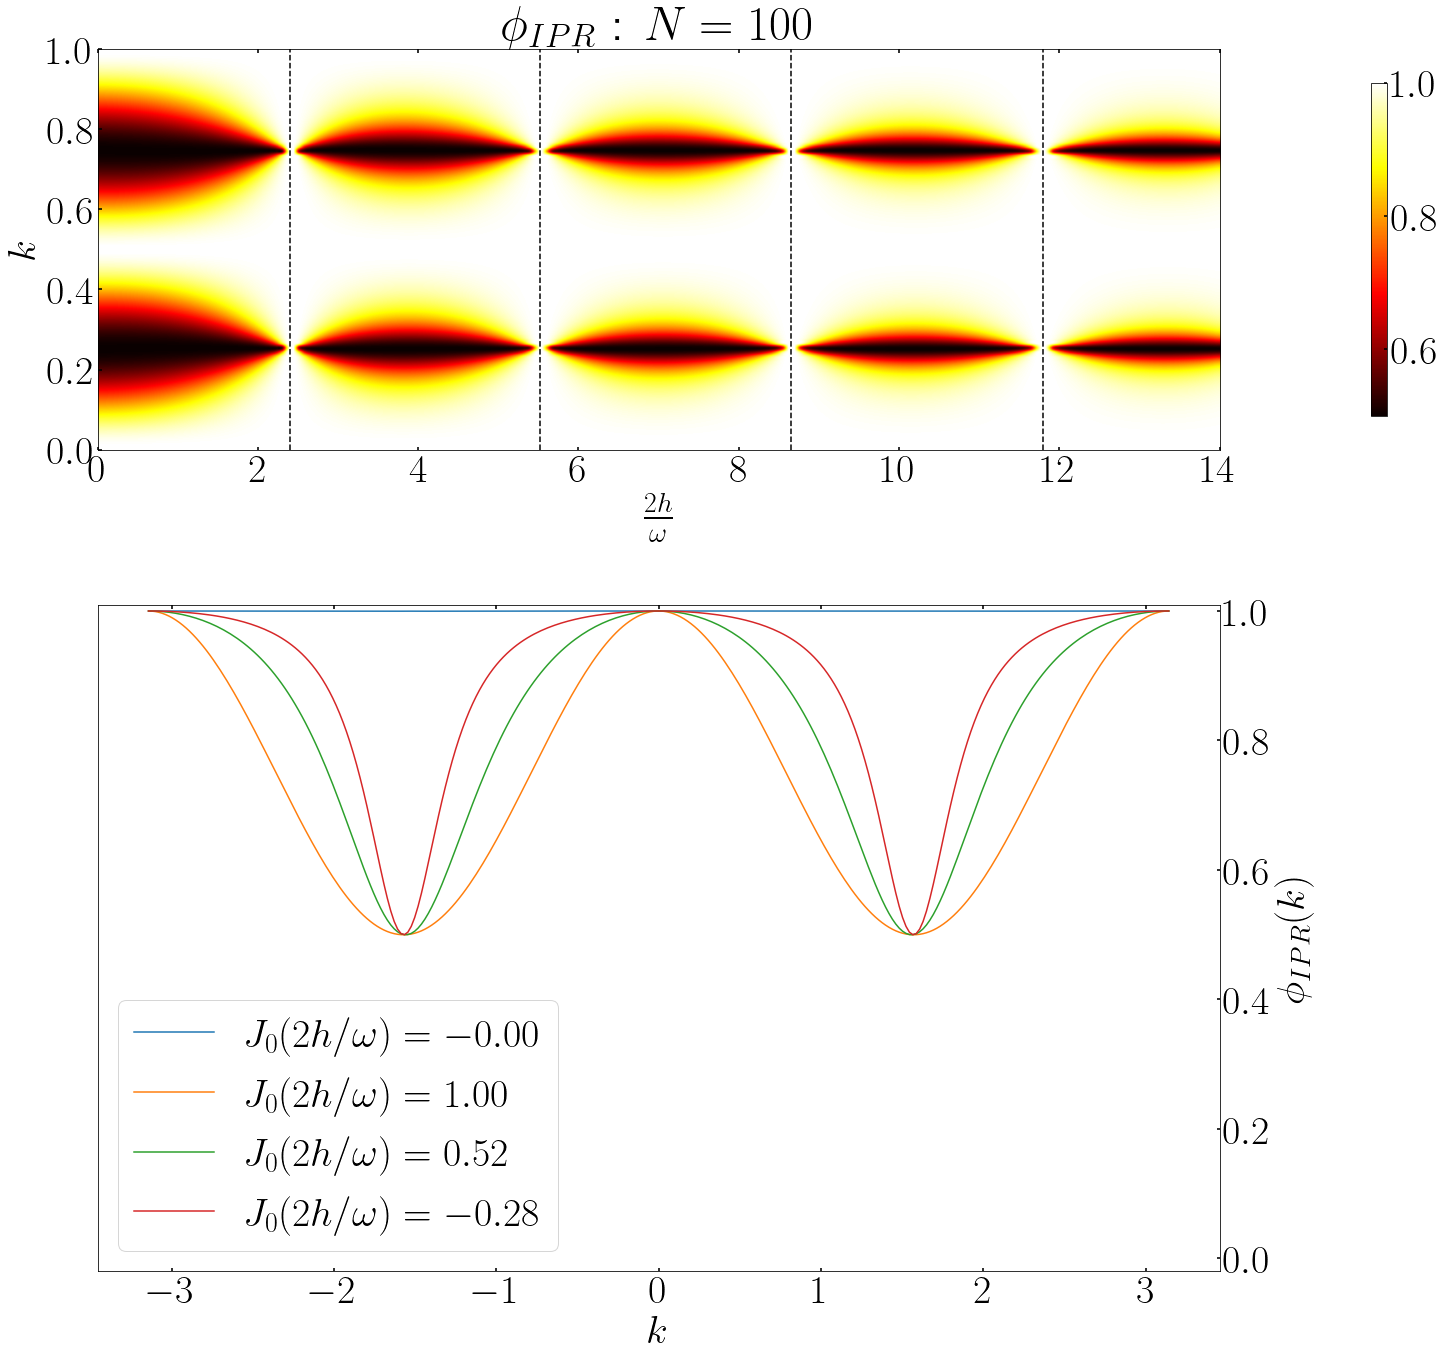

In [5]:
import matplotlib.pyplot as plt
from scipy.special import j0,jn_zeros
from scipy.interpolate import make_interp_spline

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})

freezing_pts = jn_zeros(0,4)

etas = 2 * hvals/w

fig = plt.figure(tight_layout=False, constrained_layout=True)

ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {len(fbz)}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{2h}{\omega}$')
ipr_ax.set_ylabel(r'$k$')


im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

for pt in freezing_pts:
    ipr_ax.axvline(pt, color='black', ls='--')

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.5)


#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[0], atol=1e-3))
n0 = idx[0]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]

#Intermediate IPR
idx, = np.where(np.isclose(etas, 1.5, atol=0.09))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 4.8, atol=0.2))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = fbz
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 300)
    gfg = make_interp_spline(xdata, ydata, k=3)
    crosssec_ax.plot(xnew, gfg(xnew), label=fr"$J_0(2h/\omega)={j0(etas[n]):1.2f}$")


crosssec_ax.set_xlabel(r"$k$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(k)$")
crosssec_ax.set_ylim(-0.02, 1.01)
plt.legend()
#plt.savefig("ising_ipr.png", dpi=200)
plt.show()

The plots above are for the **exact** dynamics of the TFIM in Fermionic representation, with the reduced IPR plotted for the entire Brillouin zone for a few drive amplitudes. The frequency is set to $\omega = 90$ and the IPR of one of the two Floquet modes are plotted at time $t=T$ for $4$ chosen amplitudes. As can be seen, the exact result is consistent with the RWA approximation. When $J_0(2h/\omega) = 0$, the RWA Hamiltonian vanishes, yielding an IPR of unity. At other points, the IPR is unity only when $k=\pm \pi$ (since $\Delta_k=0$) and $k=0$ (since $f_k = 0$ and the Hamiltonian for each $k$ $\sim \sigma_x$); other than that, there is "delocalization" due to the ensuing dynamics.

Finally, let us look at quantitative comparisons between the exact result and the RWA result.  We compare IPR's of the Floquet modes obtained with the zeroth and first order terms in the RWA expansion with the exact case. The three Hamiltonians whose Floquet modes are to be compared are
\begin{align*}
H_k(t) &= \sigma_z f_k + \sigma_x \Delta_k + \sigma_z h\cos{\omega t}\\
H^{(RWA)}_k(t) &= \sigma_z f_k + 2 J_0(\eta) \sigma^x \Delta_k\\
H^{(RWA2)}_k(t) &= H^{(RWA)}_k(t) - 2 J_1(\eta)\Delta_k \sigma^y\;\sin{\big(\omega t\big)}. 
\end{align*}
with $\eta=2 h/\omega$. 

In [47]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, propagator 
from qutip.floquet import floquet_modes
from scipy.special import jn

def drive_sx_rwa(t, args):
    n = args['order']
    w = args['omega']
    h = args['h']
    eta = 2*h/w
    cos_indices = np.arange(1,n+1)
        
    return np.sum([2 *jn(2*m, eta)*np.cos(2*m*w*t) for m in cos_indices])

def drive_sy_rwa(t, args):
    n = args['order']
    w = args['omega']
    h = args['h']
    eta = 2*h/w
    sin_indices = np.arange(1,n+1)          
    return np.sum([2*jn(2*m-1, eta)*np.sin((2*m-1)*w*t) for m in sin_indices])

def get_floquet_isingfermion_RWA(k, args, **kwargs):
    h = args['h']
    w = args['omega']
    eta = 2*h/w
    Dk = np.sin(k) 
    fk = np.cos(k)
    n = args['order']
    sx, sy, sz = sigmax(), sigmay(), sigmaz()
    H_rwa = Dk * sx * j0(eta) + sz * fk
    if n==0:
        H = H_rwa
    else:
        H = [H_rwa, [2 * Dk * sx, drive_sx_rwa] ,[-2 * Dk * sy, drive_sy_rwa]]
    
    T = 2 * np.pi/w
    return floquet_modes_mod(H, T, args, **kwargs)

def get_iprvals_RWA(k, params, **kwargs):
    f_states, f_energies = get_floquet_isingfermion_RWA(k, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 179 µs, sys: 15 µs, total: 194 µs
Wall time: 201 µs


Running with  10  processors for N =  30  order =  exact


200it [00:42,  4.73it/s]


Running with  10  processors for N =  30  order =  0


200it [00:39,  5.05it/s]


Running with  10  processors for N =  30  order =  1


200it [00:54,  3.66it/s]


Running with  10  processors for N =  30  order =  2


200it [01:07,  2.95it/s]


Running with  10  processors for N =  30  order =  3


200it [01:23,  2.41it/s]


Running with  10  processors for N =  30  order =  4


200it [01:35,  2.09it/s]


Running with  10  processors for N =  30  order =  5


200it [01:54,  1.74it/s]


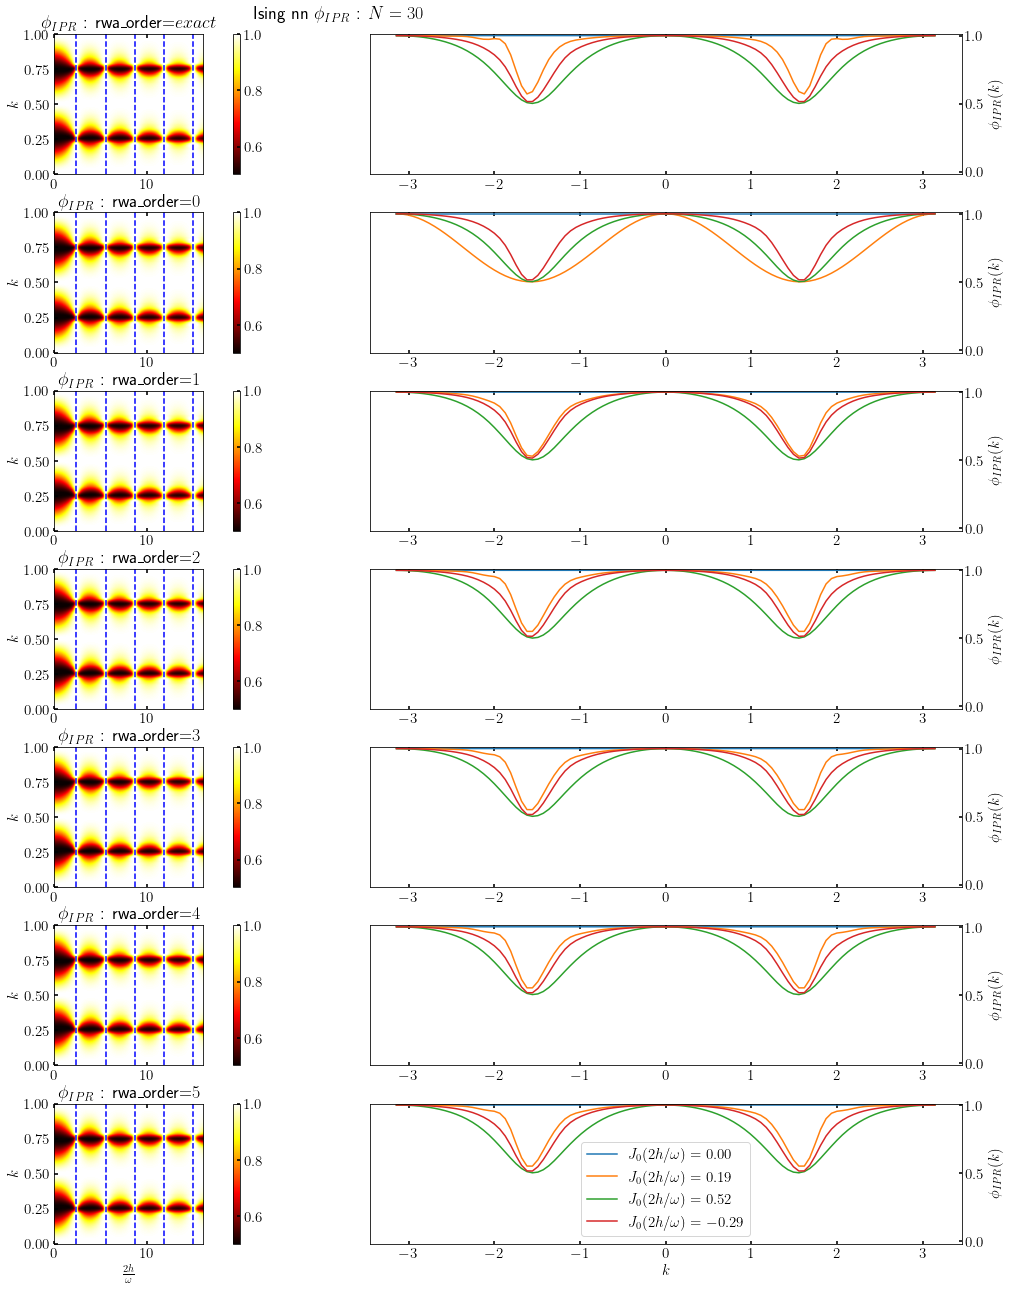

CPU times: user 52.9 s, sys: 2min 33s, total: 3min 26s
Wall time: 8min 47s


In [50]:
%%time
import numpy as np
from tqdm import tqdm
from scipy.special import jn_zeros
from qutip import Options, parfor
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

plt.rcParams.update({"figure.figsize": (6,17),"text.usetex": True,
    "font.family": "sans-serif","font.size": 15,"font.sans-serif": ["Computer Modern"]})

cpus = 10
size = 30
orders = ['exact',0,1,2,3,4,5]

freezing_pts = jn_zeros(0,5)
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2

delta = 1e-7
fbz = np.linspace(-np.pi+delta, np.pi-delta, size)
hvals = np.linspace(0.0,  omega/2 * 16.0, 195)
hvals = np.sort(np.append(hvals, hfrz))

opts = Options(rhs_reuse=False)
fig, axs = plt.subplots(len(orders), 2, figsize=(18,18))
fig.suptitle(fr'Ising nn $ \phi_{{IPR}}$ : $N = {len(fbz)}$')
fig.tight_layout()

for i,order in enumerate(orders):
    print('Running with ', cpus, ' processors for N = ', size ,' order = ', order)
    iprmat = np.empty([len(hvals), len(fbz)])
    
    for x, h in tqdm(enumerate(hvals)):
        params = {'h0':0.0, 'h':h, 'omega':omega, 'order':order, 'opts':opts}
        if order == 'exact':
            iprvals = np.array(parfor(get_iprvals_exact,fbz, [params]*size, sort=False, num_cpus=cpus))
        else:
            iprvals = np.array(parfor(get_iprvals_RWA,fbz, [params]*size, sort=False, num_cpus=cpus))
        iprmat[x,:] = iprvals[:,0]

    etas = 2 * hvals/w    

    axs[i, 0].set_title(fr'$\phi_{{IPR}}$ : rwa_order=${order}$')
    # find minimum of minima & maximum of maxima
    minmin = np.min(np.min(iprmat))
    maxmax = np.max(np.max(iprmat))
    asp = 15
    axs[i, 0].set_ylabel(r'$k$')

    im = axs[i, 0].imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                    cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

    for pt in freezing_pts:
        axs[i, 0].axvline(pt, color='blue', ls='--')

    fig.colorbar(im, ax=axs[i, 0], orientation='vertical', shrink=1.0)


    #Freezing point
    idx, = np.where(np.isclose(etas, freezing_pts[4], atol=1e-3))
    n0 = idx[0]

    #High IPR
    idx = np.where(iprmat[20:] == iprmat[20:].min())
    n1 = idx[0][0]

    #Intermediate IPR
    idx, = np.where(np.isclose(etas, 1.5, atol=0.09))
    n2 = idx[0]

    #Another IPR
    idx, = np.where(np.isclose(etas, 4.8, atol=0.2))
    n3 = idx[0]

    for j, n in enumerate([n0,n1, n2, n3]):
        xdata = fbz
        ydata =  iprmat[n]
        xnew = np.linspace(xdata.min(), xdata.max(), 100)
        gfg = make_interp_spline(xdata, ydata, k=3)
        axs[i, 1].plot(xnew, gfg(xnew), label=fr"$J_0(2h/\omega)={j0(etas[n]):1.2f}$")

    #axs[i, 1].set_xlabel(r"$k$")
    axs[i, 1].yaxis.tick_right()
    axs[i, 1].yaxis.set_label_position("right")
    axs[i, 1].set_ylabel(r"$\phi_{{IPR}}(k)$")
    axs[i, 1].set_ylim(-0.02, 1.01)

    
lastplot = len(orders)-1
axs[lastplot, 0].set_xlabel(r"$\frac{2h}{\omega}$")
axs[lastplot, 1].set_xlabel(r"$k$")
plt.legend()
figname = "ising_ipr_rwa_order_" + str(order) + "_N_" + str(size) + ".svg"
plt.savefig(figname, dpi=300)
plt.show()

### The Ising model at small drive frequency

We now show IPR plots of the Ising model at low drive frequency $h, \omega = \mathcal{O}(1)$ (specifically $\omega=2$). At such low frequencies, RWA breaks down, but localization persists nonetheless, as can be seen in the code cell below.

Running with  6  processors for N =  1000


200it [03:29,  1.05s/it]


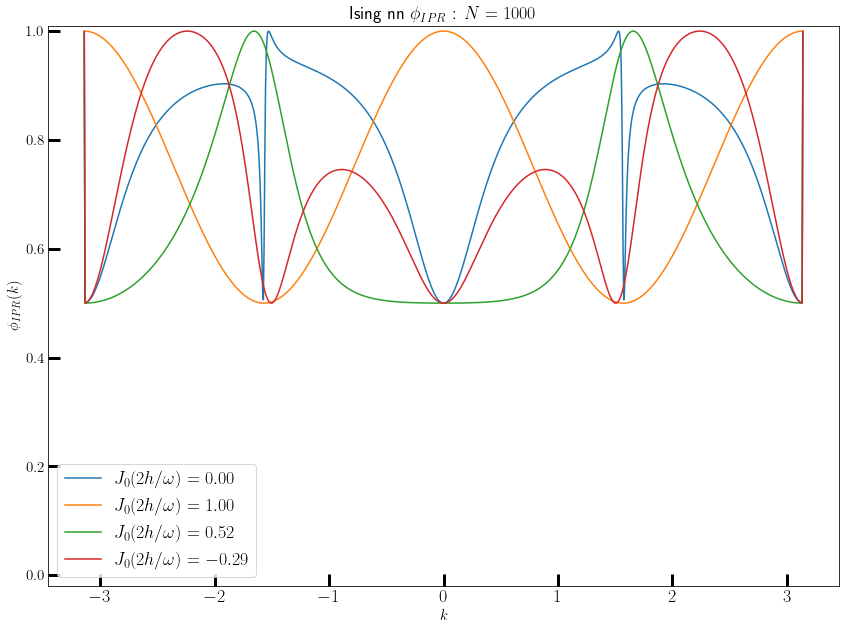

CPU times: user 4.47 s, sys: 5.31 s, total: 9.79 s
Wall time: 3min 30s


In [6]:
%%time
import numpy as np
from tqdm import tqdm
from scipy.special import jn_zeros
from qutip import Options, parfor
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (12,9),"text.usetex": True,
    "font.family": "sans-serif","font.size": 15,"font.sans-serif": ["Computer Modern"]})

cpus = 6
size = 1000

freezing_pts = jn_zeros(0,5)
omega = 2.0
w = omega
hfrz = omega * freezing_pts/2

delta = 1e-7
fbz = np.linspace(-np.pi+delta, np.pi-delta, size)
hvals = np.linspace(0.0,  omega/2 * 16.0, 195)
hvals = np.sort(np.append(hvals, hfrz))

opts = Options(rhs_reuse=False)
plt.title(fr'Ising nn $ \phi_{{IPR}}$ : $N = {len(fbz)}$')
  

print('Running with ', cpus, ' processors for N = ', size )
iprmat = np.empty([len(hvals), len(fbz)])

for x, h in tqdm(enumerate(hvals)):
    params = {'h0':0.0, 'h':h, 'omega':omega, 'opts':opts}
    iprvals = np.array(parfor(get_iprvals_exact,fbz, [params]*size, sort=False, num_cpus=cpus))
    iprmat[x,:] = iprvals[:,0]

etas = 2 * hvals/w    

# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 15

#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[4], atol=1e-3))
n0 = idx[0]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]

#Intermediate IPR
idx, = np.where(np.isclose(etas, 1.5, atol=0.09))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 4.8, atol=0.2))
n3 = idx[0]

for j, n in enumerate([n0,n1, n2, n3]):
    xdata = fbz
    ydata =  iprmat[n]
    plt.plot(xdata, ydata, label=fr"$J_0(2h/\omega)={j0(etas[n]):1.2f}$")

#axs[i, 1].set_xlabel(r"$k$")
plt.ylabel(r"$\phi_{{IPR}}(k)$")
plt.ylim(-0.02, 1.01)

plt.xlabel(r"$k$")
plt.legend()
plt.show()

As can be seen when compared with the high frequency IPR plots further above, the IPR does not drop below $0.5$, and does not scale with $N^{-1}$, even in the low frequency regime. Thus, this Floquet states never shows fully thermal behavior, and almost completely localizes for high frequencies when the amplitude is chosen such that $J_0(2h/\omega)=0$.

## The Long-Range case: LMG model

Consider the Hamiltonian of the type
\begin{equation}
\hat{H}(t) = \hat{H}_0 + \left(h \cos{(\omega t)} + h_0\right)\; \hat{H}_1,
\end{equation}

where

\begin{eqnarray}
\hat{H}_0 &=& \frac12 \sum_{ij}J_{ij}\hat{\sigma}^z_i\hat{\sigma}^z_j,\\
\hat{H}_1 &=& \sum_i\hat{\sigma}^x_i.
\end{eqnarray}
here,
\begin{equation*}
J_{ij} =\frac{J_\alpha}{N^{1-\alpha}}\frac{1}{r_{ij}}.
\end{equation*}
Putting  $\alpha = 0$ yields the **Lipkin Meshkov Glick (LMG)** model with all-to-all interaction, yielding $J_{ij} = J_0/N$. We choose to maintain the extensivity of the interaction energy by enforcing the condition
\begin{equation*}
\frac{J_0}{N} \sum_{i\neq j}1=\frac{J_0}{N}\frac{N(N-1)}{2}=1\\
\end{equation*}
yielding the Kac-norm $J_0=2/(N-1)$. Here, we have $N$ spin-$1/2$ particles in a $1-$dimensional lattice, and $i,j$ are site indices. We will now attempt a numerical evaluation of
the Floquet eigenspectrum of this system.

First, define permutation operator $P_{ij} = \displaystyle\frac{1}{2}\left(1+ \vec{\sigma}_i\cdot\vec{\sigma}_j\right)$,
and note that $[P_{ij}, H]=0$. Thus, we can reduce the problem size from the full $2^N\times 2^N$ Hilbert space
to the subspace spanned by the degenerate eigenvectors of $P_{ij}$ corresponding to a single eigenvalue, say $1$.
This is isomorphic to the subspace spanned by degenerate eigenstates of the operator $S^2=|\vec{S}|^2$ with eigenvalue
$\displaystyle\frac{N}{2}\left(\frac{N}{2}+1\right)$, where

\begin{equation}
\vec{S}=S^x\hat{x}+S^y\hat{y}+S^z\hat{z}\equiv\frac12 \sum_i \vec{\sigma}_i.
\end{equation}

Note that, since $[S^2, S^z]=0$, these are also eigenstates of $S^z$ in this so-called
TSS subspace. The corresponding eigenvalues are $Ns_n$, where $s_n=-\frac{1}{2}+\frac{n}{N}$ and the index
$n= 0 (1) N$ has $N+1$ values. Thus

\begin{equation}
S^z |s_n\rangle = Ns_n|s_n\rangle,
\end{equation}

and the matrix elements $(S^z)_{ij} = Ns_s\delta_{ij}$. Furthermore, defining ladder operators

\begin{equation}
S_\pm \equiv S^x \pm i S^y,
\end{equation}

and using the result

\begin{equation}
S_\pm |s_n\rangle = \sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n\pm 1}\right)}\;\;|s_{n\pm 1}\rangle,
\end{equation}

we can obtain the matrix elements $S^x = S_+ + S_-$ to be

\begin{equation*}
(S^x)_{nm} = \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n + 1}\right)}\;\;\delta_{n+1, m}  
                        +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n- 1}\right)}\;\;\delta_{n-1,m}\bigg]
\end{equation*}

Note that, considering $i<j$ the Hamiltonian can be readily written as
$H(t) = -\displaystyle\frac{2}{N-1}(S^z)^2 - 2(h \cos{(\omega t )} + h_0)S^x$, the matrix elements of
\begin{align*}
\left(H_0\right)_{ij} &= -\frac{4}{N-1} s^2_i \delta_{ij},\nonumber\\
\left(H_1\right)_{ij} &= \bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i + 1}\right)}\;\;\delta_{i+1, j}  
                        +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i- 1}\right)}\;\;\delta_{i-1,j}\bigg]
\end{align*}

Note that, in the continuum limit, $N\rightarrow\infty$, we can ignore the difference between adjacent values
of $s_i$. Thus, the Hamiltonian per particle becomes $h(t)\equiv \displaystyle\frac{1}{N}H(t) = h + h_0\cos{(\omega t)}h_1$, where

\begin{eqnarray}
\left(h\right)_{ij} &\approx& - 2s^2_i \delta_{ij},\nonumber\\
H_0 &\rightarrow& -2s^2\\
\left(h_1\right)_{ij} &\approx& \sqrt{1 - 4s^2_i}\left[\delta_{i+1, j}  + \delta_{i-1,j}\right]\\
H_1 &\rightarrow& \sqrt{1 - 4s^2_i}\;\;\cos{p},
\end{eqnarray}
where we have expanded the matrix elements in a basis of $e^{ipx}$.


This Hamiltonian can be simplified in the Rotated Basis as follows. Transform the Hamiltonian to the frame given by the transformation

\begin{equation*}
\hat{U}(t)=\exp \left[i \frac{h}{\omega} \sin (\omega t) \hat{H}_{1}\right]
\end{equation*}
Defining $\tau = \displaystyle\frac{h}{\omega}\sin{\omega t}$, we use the fact that $\hat{H}_1 = 2 S^x$, and the identity  $e^{i 2\tau\hat{S^{x}}} \hat{S^{z}} e^{-i 2\tau \hat{S^{x}}}=\hat{S^{z}} \cos \left(2\tau\right)+\hat{S}^{y} \sin \left(2\tau\right)$ to simplify the transformed Hamiltonian, yielding
\begin{equation*}
\tilde{H}(t)= -\frac{1}{N-1}\Bigg[\big(S^z\big)^2 \big(1+\cos{4\tau}\big) + \big(S^y\big)^2 \big(1-\cos{4\tau}\big) + \big\{S^y, S^z\big\}\sin{4\tau}\Bigg] - 2 h_0 S^x
\end{equation*}

Now, we know that $\hat{S}^{2}=\big(\hat{S}^x\big)^{2}+\big(\hat{S}^y\big)^{2}+\big(\hat{S}^z\big)^{2}=\frac{N}{2}\left(\frac{N}{2}+1\right)$ when the system is confined to the TSS subspace. In addition, we define $\eta\equiv 4h/\omega$ and use the Jacobi-Anger formulae

\begin{align*}
\cos \big(\eta \sin\omega t\big) &= J_{0}(\eta)+2 \sum_{n=1}^{\infty} J_{2 n}(\eta) \cos (2 n \omega t) \\
\sin \big(\eta \sin\omega t\big) &= 2 \sum_{n=1}^{\infty} J_{2 n-1}(\eta)\sin [(2 n-1) \omega t]
\end{align*}
to simplify the expression for $\tilde{H}(t)$. Finally, we assume that the drive frequency $\omega$ is large enough that all harmonic terms in the Hamiltonian can be averaged out over discernible time scales. This yields the Hamiltonian in the Rotated Wave Approximation (RWA) to be (ignoring constant terms in the addition)

\begin{equation*}
\tilde{H}_{\mathrm{RWA}}= \frac{\big(\hat{S}^x\big)^{2}}{N-1} - 2h_0 \hat{S}^x - \frac{J_0(\eta)}{N-1}\bigg[\big(\hat{S}^z\big)^{2} - \big(\hat{S}^y\big)^{2} \bigg]
\end{equation*}


Now, if the drive amplitude $h$ is adjusted such that $\eta$ lies at a root of $J_0(\eta)$ (the localization point), the RWA Hamiltonian is diagonal in the representation of the transverse field $\hat{S}^x$, yielding an IPR of unity in that representation, similar to the Ising case. Note however, that if the DC transverse field $h_0$ is set to $0$, then, at the localization point, the RWA Hamiltonian $\tilde{H}_{\mathrm{RWA}}\sim
\big(\hat{S}^x\big)^2$, each of whose eigenvalues (given by $\big(\frac{N}{2}-m\big)^2$ where $m \in 0(1)N$, and $\big(\frac{N}{2}-m\big)$  are the eigenvalues of $\hat{S}^x$) are **two-fold degenerate. This produces infinitely many (Floquet) eigenmodes in the degenerate subspace whose IPRs may not always be unity** in the $S^x$ representation. Thus, the absence of the DC field may produce delocalization in the Floquet states even at the localization points, and this necessitated the inclusion of a DC field $h_0$ in order to break the symmetry.
Finally, note that not all values of the DC field $h_0$ removes all degeneracies in $\tilde{H}_{\mathrm{RWA}}$. To see this, note that, at the localization point, the eigenvalues of $\tilde{H}_{\mathrm{RWA}}$ are given by

\begin{equation*}
\rm{Eigs}\bigg[\tilde{H}_{\mathrm{RWA}}\bigg] = \frac{\bigg(\frac{N}{2}-m\bigg)^2}{N-1} - 2h_0 \bigg(\frac{N}{2}-m\bigg).
\end{equation*}

In order to ensure that no degeneracies occur, we have to adjust $h_0$ to ensure that for any two integers $m_1, m_2 \leq N$  the condition below is always met


\begin{equation*}
\frac{\bigg(\frac{N}{2}-m_1\bigg)^2}{N-1} - 2h_0 \bigg(\frac{N}{2}-m_1\bigg) \neq \frac{\bigg(\frac{N}{2}-m_2\bigg)^2}{N-1} - 2h_0 \bigg(\frac{N}{2}-m_2\bigg).
\end{equation*}

If $N\gg 1$ (substantially large), then this condition can be met by assuring that $(1-2h_0)^{-1}$ is never an integer that is divisible by $N$. To ensure this in our simulations below, we keep $h_0$ at an **irrational** value of $\sqrt{3}$.


This result is tentatively supported by exact simulations, as can be seen in the plots below. There, we show plots of the IPR of the Floquet mode $|\phi^n\rangle$ for all $n$ corresponding to eigenvalues of $S^x$ for a fixed eigenvalue of $S^2 = N/2\big(N/2 + 1\big)$. The IPR is thus
\begin{equation*}
\phi_{IPR}(n) = \sum_m \left\vert\langle m\vert\phi^n\rangle\right\vert^4,
\end{equation*}
where $|m\rangle$ is the $m^{th}$ eigenstate of $\hat{S}^x$

## References
[1] Check T. Mori's paper equation (12): Mori, T. , arXiV: 1810.01584 (2018)


Now, we look at numerical simulations for $H(t)$ via the IPR of the Floquet state in the representation of the transverse field *i.e.* the eigenstates of $S^x$. We're keeping $\omega = 90$ as a large enough value for RWA to hold, and $N=\mathcal{O}(10^2)$ which our computational resources will allow. 

In [2]:
from qutip import mesolve, basis, jmat

def drive(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.cos(w*t) + h0

def get_hamiltonians(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1

def floq_evolv(args):
    N = args['N']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive]]
    f_states, _ = floquet_modes_mod(H, T, args=args)
    return f_states


print("Definitions complete!")

Definitions complete!


In [3]:
%%time
from qutip import Qobj, jmat, Options
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros

N = 50
h0 = np.sqrt(3)
omega = 90
nprocs = 14

w = omega

hsteps = 70
h1 = (1/4) * omega * 0.01
h2 = (1/4) * omega * 16.0 

freezing_pts = jn_zeros(0, 5)

hroots = freezing_pts * omega/4

hs = np.linspace(h1, h2, hsteps)

hs = np.sort(np.append(hs, hroots))

hs = [hroots[1]]

p = Pool(processes = nprocs)          
print("running for N = ", N, "with",nprocs,"processors")  

#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)
params = [{'h0':h0, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
f_stateslist = p.map(floq_evolv,tqdm(params, position=0, leave=True))

iprmat = np.zeros((len(hs),2*N+1))

sx = jmat(N,"x")
en, st = sx.eigenstates()

print("\n Done. Now calculating IPR ...")
for xx,h in enumerate(hs):
    f_states = f_stateslist[xx]
    iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
print("Exact simulation complete!")

running for N =  50 with 14 processors


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 484.55it/s]



 Done. Now calculating IPR ...
Exact simulation complete!
CPU times: user 797 ms, sys: 839 ms, total: 1.64 s
Wall time: 5.49 s


In [5]:
iprmat, hs, omega

(array([[0.95932284, 0.96084977, 0.96798254, 0.96902523, 0.96028111,
         0.96147658, 0.95977179, 0.97121983, 0.97010526, 0.96601968,
         0.95893516, 0.96697986, 0.97236597, 0.98172156, 0.9804253 ,
         0.96510437, 0.97354058, 0.97913376, 0.97785142, 0.98301791,
         0.95860952, 0.97474037, 0.98430948, 0.96216021, 0.96423613,
         0.9759619 , 0.95834654, 0.99866357, 0.99915594, 0.96289918,
         0.96341703, 0.9581467 , 0.97658251, 0.97720158, 0.9855912 ,
         0.97845563, 0.99953698, 0.99979828, 0.9753311 , 0.99806807,
         0.97972012, 0.99737744, 0.95793772, 0.95801035, 0.97410105,
         0.98226381, 0.96369185, 0.95792887, 0.97289602, 0.98353428,
         0.962649  , 0.98099094, 0.95798377, 0.98479772, 0.98604931,
         0.99993129, 0.97171949, 0.96193383, 0.95810224, 0.98685779,
         0.99574192, 0.98728407, 0.98849681, 0.96453646, 0.97057476,
         0.95828395, 0.99481205, 0.98968218, 0.96946496, 0.95852848,
         0.99381712, 0.96127314, 0

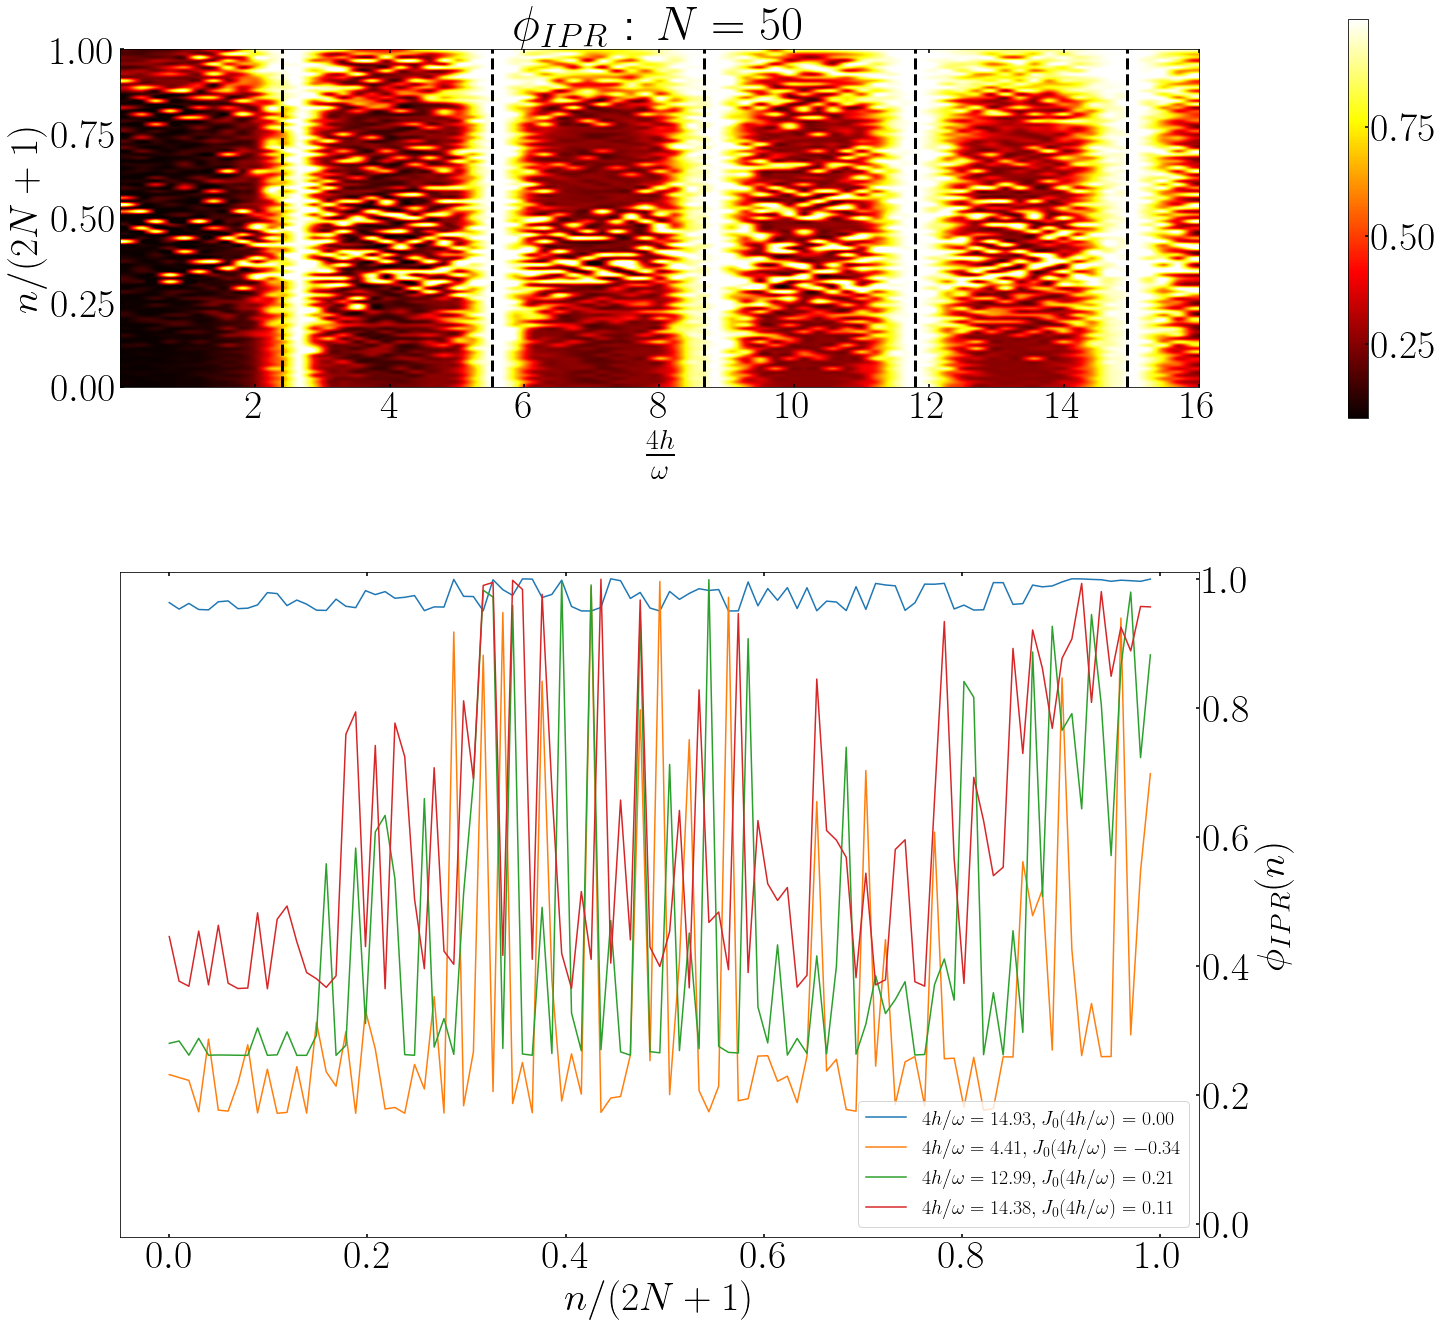

In [4]:
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.interpolate import make_interp_spline

from scipy.signal import savgol_filter

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})


from scipy.special import jn_zeros
delta= 0.0

freezing_pts = jn_zeros(0,5) + delta

etas = 4 * hs/w

fig = plt.figure(constrained_layout=True)

ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {N}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{4h}{\omega}$')
ipr_ax.set_ylabel(r'$n/(2N+1)$')

for pt in freezing_pts:
    ipr_ax.axvline(x=pt, color='black', linestyle="--",linewidth=3.0)

im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.6)


#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[-1], atol=0.03))
n0 = idx[0]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]+20

#Intermediate IPR
idx, = np.where(np.isclose(etas, 13.0, atol=0.15))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 14.5, atol=0.15))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = np.arange(2*N+1)/(2*N+1)
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 300)
    gfg = make_interp_spline(xdata, ydata, k=3)
    #crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
    crosssec_ax.plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")


crosssec_ax.set_xlabel(r"$n/(2N+1)$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(n)$")
crosssec_ax.set_ylim(-0.02, 1.01)
plt.legend(loc="lower right", fontsize=20)
plt.show()

The top panel has a density plot of the IPR of the Floquet states, with $\eta=4h/\omega$ on the abscissa and the spin index $m/(2N+1)$ on the ordinate. The dashed vertical lines correspond to roots of $J_0(\eta)$. As can be seen, the IR is essentially unity at large roots of $J_0(\eta)$, indicating complete Many Body localization. However, there is some departure from unity at the smallest root of $J_0(\eta)$. This is due to the fact that, at the smallest root of $J_0(\eta)\approx 2.405$, the amplitudes of the contributions of the higher order terms in the RW expansion , which are of $\mathcal{O}(J_n(\eta))$, are large enough to contribute to delocalization.

The bottom panel contains cross sections of the full IPR plot for select values of $\eta$ as indicated in the legend. Here, we can see more clearly that, when the drive amplitude $h$ is adjusted to make $J_0(\eta)\neq 0$, the Floquet States are mixed, but not entirely thermal, since the IPR does not fall to $\mathcal{O}(N^{-1})$, indicating that localization persists to some extent always.

For completeness, we also show plots for the case where the DC field $h_0 = 0$ below.

In [16]:
%%time
from qutip import Qobj, jmat, Options
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros

delta = 0.0
freezing_pts = jn_zeros(0,5)
####################################################################################################
#
#                                     Exact Dynamics
#
########################################import############################################################

N = 50
h0 = 0.0
omega = 90
nprocs = 14

w = omega

hsteps = 70
h1 = (1/4) * omega * 0.01
#h1 = 0
h2 = (1/4) * omega * 16.0 

hroots = freezing_pts * omega/4

hs = np.linspace(h1, h2, hsteps)

hs = np.sort(np.append(hs, hroots))

p = Pool(processes = nprocs)          
print("running for N = ", N, "with",nprocs,"processors")  

#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)
params = [{'h0':0, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
f_stateslist = p.map(floq_evolv,tqdm(params, position=0, leave=True))


iprmat = np.zeros((len(hs),2*N+1))

sx = jmat(N,"x")
en, st = sx.eigenstates()

print("\n Done. Now calculating IPR ...")
for xx,h in enumerate(hs):
    f_states = f_stateslist[xx]
    iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
print("Exact simulation complete!")


running for N =  50 with 14 processors


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 22888.01it/s]



 Done. Now calculating IPR ...
Exact simulation complete!
CPU times: user 14.3 s, sys: 445 ms, total: 14.8 s
Wall time: 6min 24s


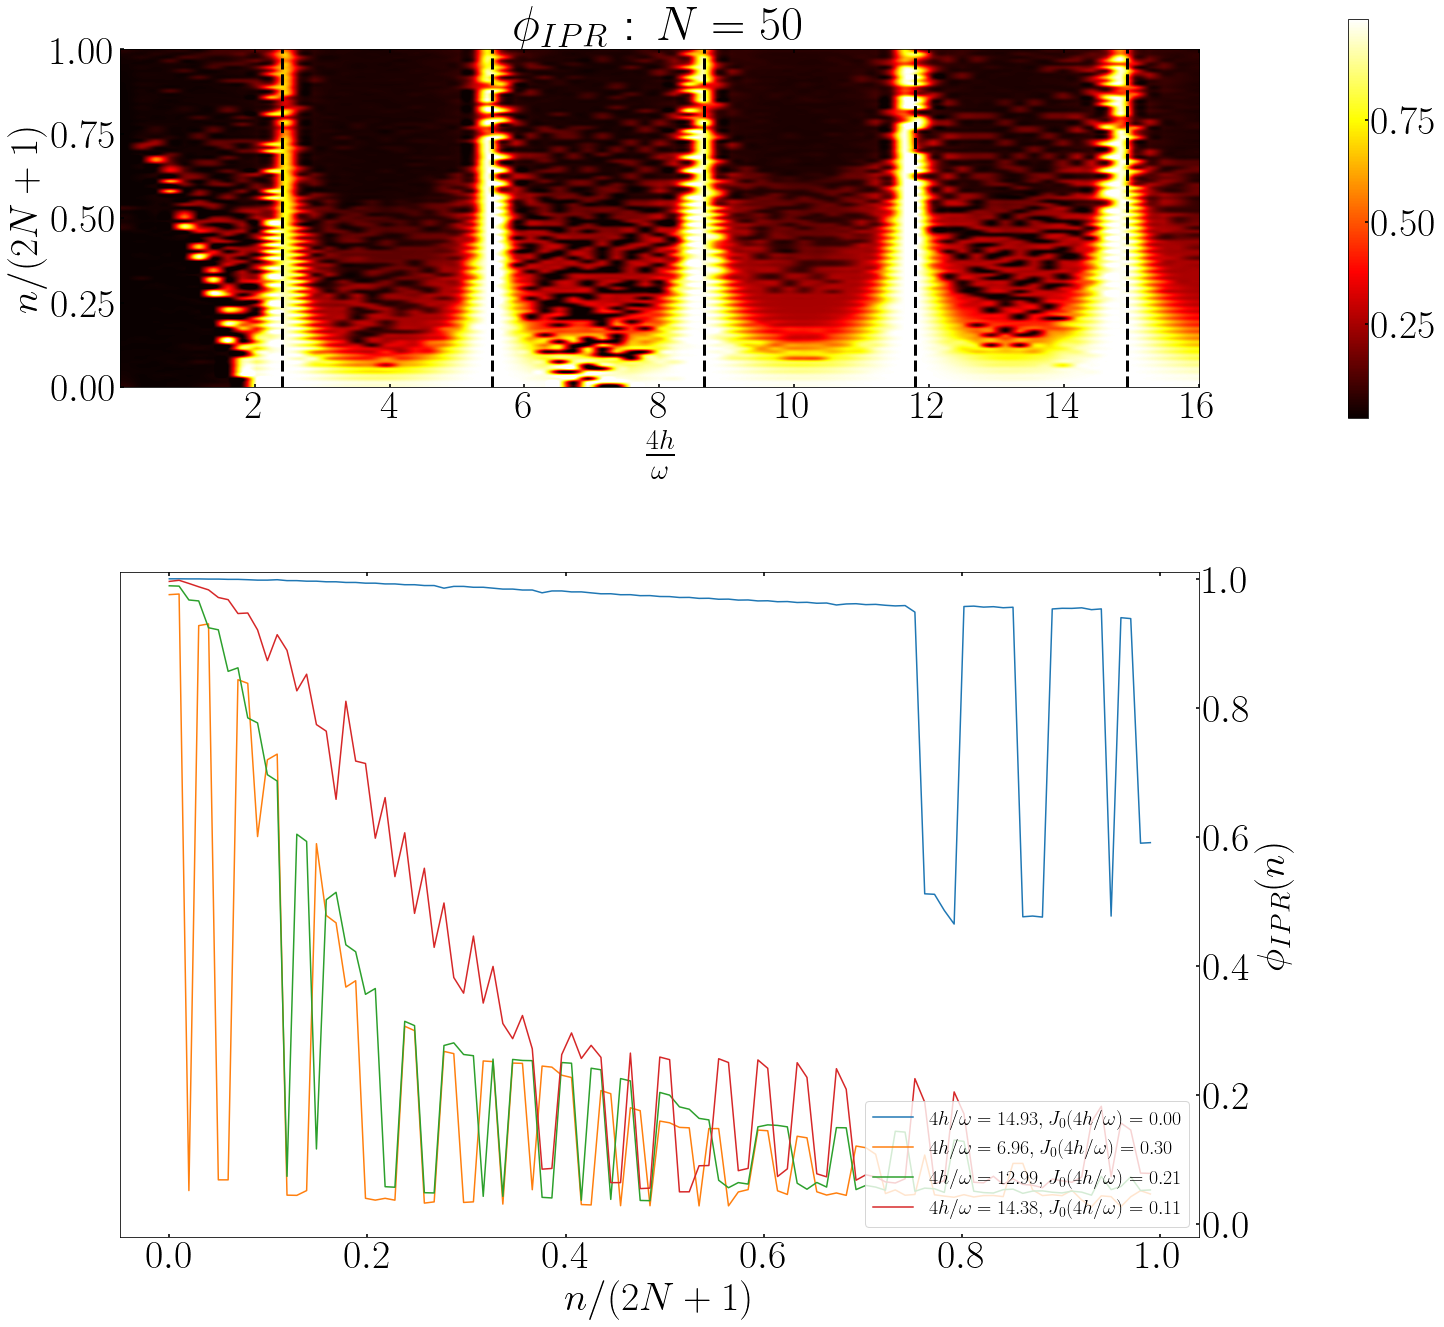

In [17]:
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.interpolate import make_interp_spline

from scipy.signal import savgol_filter

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})


from scipy.special import jn_zeros
freezing_pts = jn_zeros(0,5) 

etas = 4 * hs/w

fig = plt.figure(constrained_layout=True)

ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {N}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{4h}{\omega}$')
ipr_ax.set_ylabel(r'$n/(2N+1)$')

for pt in freezing_pts:
    ipr_ax.axvline(x=pt, color='black', linestyle="--",linewidth=3.0)

im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.6)


#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[-1], atol=0.05))
n0 = idx[-1]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]+20

#Intermediate IPR
idx, = np.where(np.isclose(etas, 13.0, atol=0.15))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 14.5, atol=0.15))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = np.arange(2*N+1)/(2*N+1)
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 300)
    gfg = make_interp_spline(xdata, ydata, k=3)
    #crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
    crosssec_ax.plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")


crosssec_ax.set_xlabel(r"$n/(2N+1)$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(n)$")
crosssec_ax.set_ylim(-0.02, 1.01)
plt.legend(loc="lower right", fontsize=20)
plt.show()

We can see the role of degeneracy in the RWA hamiltonian. Floquet states in the degenerate subspace are (essentially) chosen arbitrarily by the simulation when running at the localization point, leading to deviation from unity in the IPR.

### Conclusion
As long as there is an appropriate DC field, $S^x$ is mostly conserved and $H_F$ is **mostly** diagonal in the $S^x$ representation at freezing. The small deviations from this conservation occur due to the role of higher order terms in the Fourier expansion of the Hamiltonian in the rotated basis that contribute additional time-periodic terms to the RWA Hamiltonian, as can be seen below.


# RWA to higher orders

The full Hamiltonian for the LMG model in the rotated basis is

\begin{multline*}
\tilde{H}(t)\sim \frac{\big(\hat{S}^x\big)^{2}}{N-1} - 2h_0 \hat{S}^x - \frac{J_0(\eta)}{N-1}\bigg[\big(\hat{S}^z\big)^{2} - \big(\hat{S}^y\big)^{2} \bigg] - \frac{2}{N-1}\sum^\infty_{n=1}\;J_{2n}(\eta)\;\Big[\big( \hat{S}^z\big)^2 - \big( \hat{S}^y\big)^2\Big]\;\cos{\big(2n\omega t\big)}\\
- \frac{2}{N-1}\sum^\infty_{n=1}J_{2n-1}(\eta)\;\big\{ \hat{S}^y,  \hat{S}^z \big\}  \;\sin{\Big[\big(2n-1\big)\omega t\Big]}
\end{multline*}

In [36]:
###   RWA CODES

def get_hamiltonians_RWA(N, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  1.0/(N-1)   
    
    H0 = -kn * (N/2 *(N/2+1) - sx*sx) - h0 * 2*sx
    H0 += (-kn) * (sz*sz - sy*sy) * j0(4*h/w)
    H1 = -2 * kn * (sz*sz - sy*sy)
    H2 = -2 * kn * (sy*sz + sz*sy)
    return H0,H1,H2

def floq_evolv_RWA(args):
    N = args['N']
    h = args['h']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    order = args['order']
    omega = args['omega']
    H0, H1, H2 = get_hamiltonians_RWA(N,args)
    if order==0:
        f_states, _ = floquet_modes_mod(H0, T, args=args)
    else:
        H = [H0]
        for n in np.arange(1,order+1,2): 
            sin_drive = 'sin((' + str(n) + '*omega'')*t)'
            H.append([H2*jn(n,4*h/w), sin_drive])
            
        for m in np.arange(2,order+1,2):     
            cos_drive = 'cos((' + str(m) + '*omega'')*t)'
            H.append([H1*jn(m, 4*h/w), cos_drive])
            
        f_states, _ = floquet_modes_mod(H, T, args=args)
        
    return f_states

print("Definitions complete!")

Definitions complete!


## Comparison of IPR: Exact with RWA

running for 2N+1 =  41 with 4 processors
running for order =  exact


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2371.00it/s]


running for order =  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 3926.33it/s]


running for order =  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4851.71it/s]


running for order =  5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 7070.04it/s]


running for order =  10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 5346.47it/s]


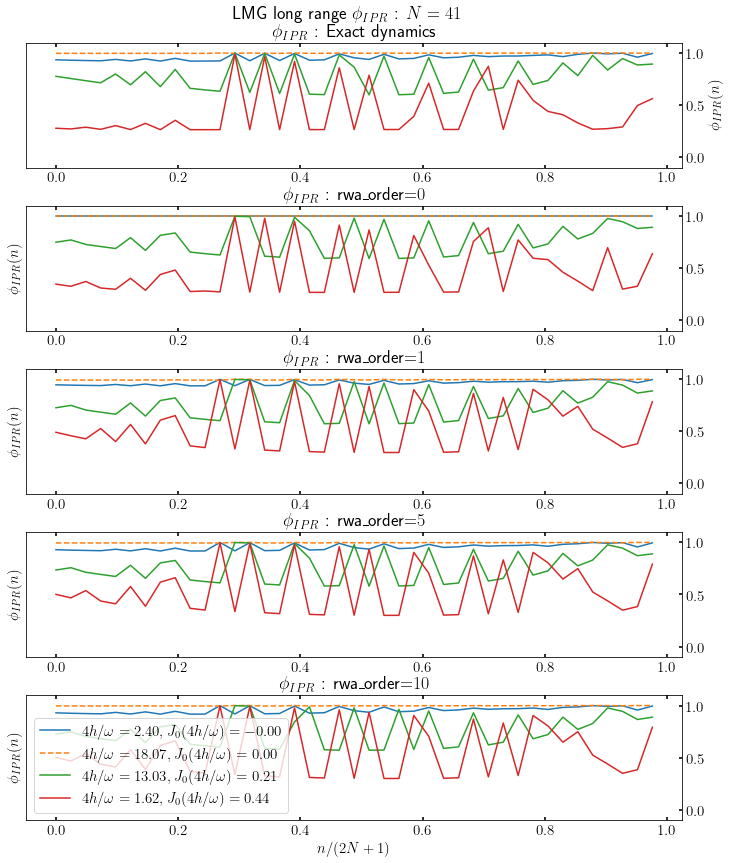

CPU times: user 4.87 s, sys: 411 ms, total: 5.28 s
Wall time: 26.6 s


In [46]:
%%time
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator, jmat, Options
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros, jn
from scipy.interpolate import make_interp_spline
plt.rcParams.update({
    "figure.figsize": (10,12),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Computer Modern"]})

delta = 0.0
freezing_pts = jn_zeros(0,20)+delta

styles = ['solid', 'dashed', 'solid', 'solid']

N = 20
h0 = np.sqrt(3)
omega = 90
nprocs = 4
orders = ['exact', 0, 1, 5, 10]
w = omega
h1, h2, h3, h4 = freezing_pts[0],freezing_pts[5], 13.03, 1.62
hs = 1/4*omega * np.array([h1, h2, h3, h4])
etas = 4 * hs/w

p = Pool(processes = nprocs)          
print("running for 2N+1 = ", 2*N+1, "with",nprocs,"processors")  
fig, axs = plt.subplots(len(orders), 1)
fig.suptitle(fr'LMG long range $ \phi_{{IPR}}$ : $N = {2*N+1}$')
fig.tight_layout()

for i,order in enumerate(orders):
    print('running for order = ',order)
    if order == 'exact':
        p = Pool(processes = nprocs)         
        #Qutip Solver Options
        opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)
        params = [{'h0':h0, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
        f_stateslist = p.map(floq_evolv,tqdm(params, position=0, leave=True))
        
        iprmat = np.zeros((len(hs),2*N+1))
        sx = jmat(N,"x")
        en, st = sx.eigenstates()

        for xx,h in enumerate(hs):
            f_states = f_stateslist[xx]
            iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
        
        axs[i].set_title(fr'$\phi_{{IPR}}$ : Exact dynamics')
        
        #Freezing point
        idx, = np.where(np.isclose(etas, h1))
        n1 = idx[0]

        #Intermediate IPR
        idx, = np.where(np.isclose(etas, h2))
        n2 = idx[0]
        idx, = np.where(np.isclose(etas, h3))
        n3 = idx[0]
        idx, = np.where(np.isclose(etas, h4))
        n4 = idx[0]

        for j, n in enumerate([n1, n2, n3, n4]):
            xdata = np.arange(2*N+1)/(2*N+1)
            ydata =  iprmat[n]
            axs[i].plot(xdata, ydata,\
                        label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$",\
                        linestyle = styles[j])
            #axs[i].plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
            

        #axs[i, 1].set_xlabel(r"$n/(2N+1)$")
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel(r"$\phi_{{IPR}}(n)$")
        axs[i].set_ylim(-0.1, 1.1)
        
    else:
        #print('running for order = ',order)
        opts = Options(nsteps=1e10, num_cpus=nprocs)
        params = [{'h0':h0, 'h':h, 'omega':omega, 'N':N, 'order':order, 'opts':opts} for h in hs]
        f_stateslist = p.map(floq_evolv_RWA,tqdm(params, position=0, leave=True))

        iprmat = np.zeros((len(hs),2*N+1))
        sx = jmat(N,"x")
        en, st = sx.eigenstates()


        for xx,h in enumerate(hs):
            f_states = f_stateslist[xx]
            iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]

        axs[i].set_title(fr'$\phi_{{IPR}}$ : rwa_order=${order}$')
        
        #Freezing point
        idx, = np.where(np.isclose(etas, h1))
        n1 = idx[0]

        #Intermediate IPR
        idx, = np.where(np.isclose(etas, h2))
        n2 = idx[0]
        idx, = np.where(np.isclose(etas, h3))
        n3 = idx[0]
        idx, = np.where(np.isclose(etas, h4))
        n4 = idx[0]

        for j, n in enumerate([n1, n2, n3, n4]):
            xdata = np.arange(2*N+1)/(2*N+1)
            ydata =  iprmat[n]
            axs[i].plot(xdata, ydata,\
                        label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$",\
                        linestyle=styles[j])
            #axs[i].plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")

        #axs[i, 1].set_xlabel(r"$n/(2N+1)$")
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("left")
        axs[i].set_ylabel(r"$\phi_{{IPR}}(n)$")
        axs[i].set_ylim(-0.1, 1.1)

lastplot = len(orders)-1
axs[lastplot].set_xlabel(r"$n/(2N+1)$")
plt.legend(loc = 'lower left', fontsize = 15)
figname = 'comprasion_LMG_'+str(N)+'_highFr90_exact_nd_rwa.jpeg'
plt.savefig(figname, dpi = 400)
plt.show()


# Classical Lipkin Dynamics

In the continuum limit, the Lipkin system can be described by the $p,q$ Hamiltonian:
\begin{equation*}
H = -2 q^2 - h(t)\;\sqrt{1-4q^2}\;\cos{p},
\end{equation*}
which yields the Hamiltonian dynamical system 
\begin{align*}
\frac{dq}{dt} &= h(t)\;\sqrt{1-4q^2}\;\sin{p}\\
\frac{dp}{dt} &= 4q\bigg[1-\frac{h(t)\cos{p}}{\sqrt{1-4q^2}}\bigg]
\end{align*}
Below are the Poincare sections (strobed at integer multiples of $T=2\pi/\omega$) of the ensuing dynamics for $h(t)=h\cos{\omega t}$ for two cases, one for which $J_0(4h/\omega)=0$ and one at lower value of $h$. These are compaared with the Husimi Q-functions of the Floquet States obtained as above. The quantum phase space is described by the *Spectral Average* of the Husimi functions of all the Floquet modes $|\phi^n\rangle$ for the chosen value of $S^2$, *i.e.* for a coherent state $|q, p\rangle$, we plot
\begin{equation*}
H(q,p)\equiv \frac{1}{\big(2N+1\big)\pi}\sum_n \langle q,p\vert \phi^n\rangle\langle\phi^n\vert q,p\rangle
\end{equation*}

These are shown for two cases, small $\omega$, where the classical plots are chaos dominated, and large $\omega$, where they are regular.

In [5]:
# Lipkin Model Cross-Section
import numpy as np
from scipy.integrate import odeint, odepack
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
from scipy.special import j0, jn_zeros
import warnings

warnings.filterwarnings("ignore")
from qutip import Options
from qutip.wigner import qfunc

# Maximum number of strobes
nmax = 1000
# Number of Processors
nprocs = 22

def lmg(z, t, h0, h, w):
    q, p = z
    drive = h0 + h * np.cos(w * t)
    sterm = np.sqrt(1.0 - 4.0 * q * q)
    qdot = drive * sterm * np.sin(p)
    pdot = 4.0 * q * (1.0 - (drive * np.cos(p)/sterm) )
    return [qdot, pdot]

def poincare_sec(x0, p0, nmax, args):
    h0, h, omega = args
    T = 2.0 * np.pi/omega
    t = T * np.arange(nmax)
    init = [x0,p0]
    points = odeint(lmg, init, t, args=args)
    points[:,1] = points[:,1] % (2.0 * np.pi)
    return points

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 20,
    "font.sans-serif": ["Computer Modern"]})

# Initial Conditions for classical poincare
n_ic = 15
init_x = np.linspace(-0.45, 0.45, n_ic)
near_zero = np.linspace(-0.01, 0.01, 10)
init_x = np.sort(np.append(init_x, near_zero))
init_p = np.linspace(0.0, 2.0 * np.pi, n_ic)
init_p = np.sort(np.append(init_p, [0.1, np.pi + 0.2]))
xv, pv = np.meshgrid(init_x, init_p, indexing='ij')

# Initial Conditions for quantum husimi
# Choose a size
N = 150
#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=13, openmp_threads=13)
n_Q = 100
Q_qvals = np.linspace(-0.5, 0.5, n_Q)
Q_pvals = np.linspace(0.0, 2.0 * np.pi, n_Q)
Q_pvals = np.sort(np.append(Q_pvals, [0.1, np.pi + 0.2]))

Poincare section dynamics for h = 1.503015973559858 w = 2.5 with 22 processes ...
Done in 162.3603835105896 secs
Husimi plots for h = 1.503015973559858 w = 2.5 with 22 processes ...
Done in 110.69694375991821 secs
Poincare section dynamics for h = 54.10857504815489 w = 90.0 with 22 processes ...
Done in 103.8253378868103 secs
Husimi plots for h = 54.10857504815489 w = 90.0 with 22 processes ...
Done in 70.47748756408691 secs


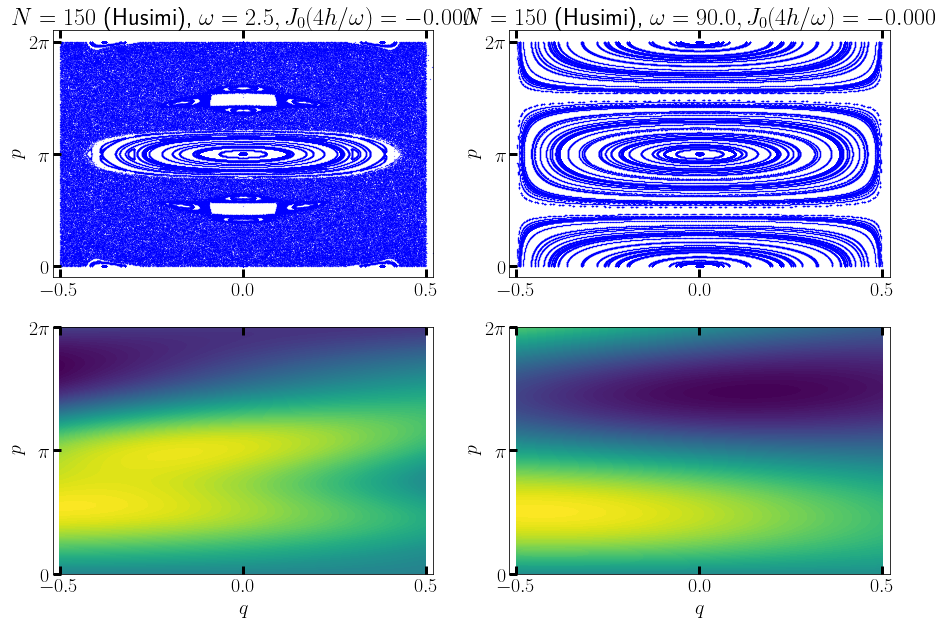

In [6]:
if __name__ == '__main__':
    # Drive parameters
    h0 = np.sqrt(3)
    omegas = [2.5, 90.0]
    eta = jn_zeros(0,1)
    eta = eta[0]
    
    n_omegas = len(omegas)
    fig, axs = plt.subplots(2, n_omegas, figsize=(15, 10))

    for i, w in enumerate(omegas):
        h_frz = eta * w/4
        print(f"Poincare section dynamics for h = {h_frz} w = {w} with {nprocs} processes ...")   
        start = time.time()
        with Pool(processes = nprocs) as p:
            poincare_data = p.starmap(poincare_sec,[(x0, p0, nmax, (h0, h_frz, w)) for x0, p0 in zip(xv.flatten(), pv.flatten())])
        
        poincare_data = np.vstack(poincare_data)
        qvals = poincare_data[:,0]
        pvals = poincare_data[:,1]
        elapsed =  (time.time() - start)
        print(f"Done in {elapsed} secs")
        
        axs[0,i].set_title(r'$N={:d}$ (Husimi), $\omega = {:2.1f}, J_0(4 h/\omega) = {:1.3f}$'.format(N,w,j0(4*h_frz/w)))
        axs[0,i].scatter(qvals, pvals , color='blue', marker='.', s=.1)  
        
        #Now for the quantum case
        print(f"Husimi plots for h = {h_frz} w = {w} with {nprocs} processes ...")  
        start = time.time()
        params = {'h0':0, 'h':h_frz, 'omega':w, 'N':N, 'opts':opts} 
        H0, H1 = get_hamiltonians(N)
        H = [H0,[H1,drive]]
        T = 2 * np.pi/w
        evecs_f, _ = floquet_modes_mod(H, T, args=params)
        Q_fstate = 0
        for fstate in evecs_f:
            Q_fstate += qfunc(fstate, Q_qvals, Q_pvals)
        
        elapsed =  (time.time() - start)
        print(f"Done in {elapsed} secs")
        axs[1,i].contourf(Q_qvals, Q_pvals, Q_fstate/(2*N+1), 100)
        axs[1,i].set_xlabel(r'$q$')
    
    
    #Formatting
    x_tick = np.array([-0.5, 0.0, 0.5])
    unit   = 1.0
    p_tick = np.arange(0.0, 2.0 + unit, unit)
    p_label = [r"$0$", r"$\pi$", r"$2\pi$"]
    
    for ax in axs.flatten():
        ax.set_xticks(x_tick)
        ax.set_xlim(-0.52, 0.52)
        ax.set_yticks(p_tick*np.pi, p_label)
        ax.set_ylabel(r"$p$")
        ax.tick_params(direction='in', length=8, width=3)
    
    #plt.savefig("lmg_poincare01.svg")
    plt.show()

In [11]:
np.sum(Q_fstate/(2*N+1))

5.370807734293001

## IPR at low drive frequencies

At low drive frequencies, the onset of chaos in the thermodynamic limit suggests that the IPR of the Floquet states should be delocalized. This is shown in the output of the code cell below.

In [9]:
np.amin(Q_fstate/(2*N+1))

0.0005011595836620448

running for 2N+1 =  101 with 4 processors


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1894.45it/s]


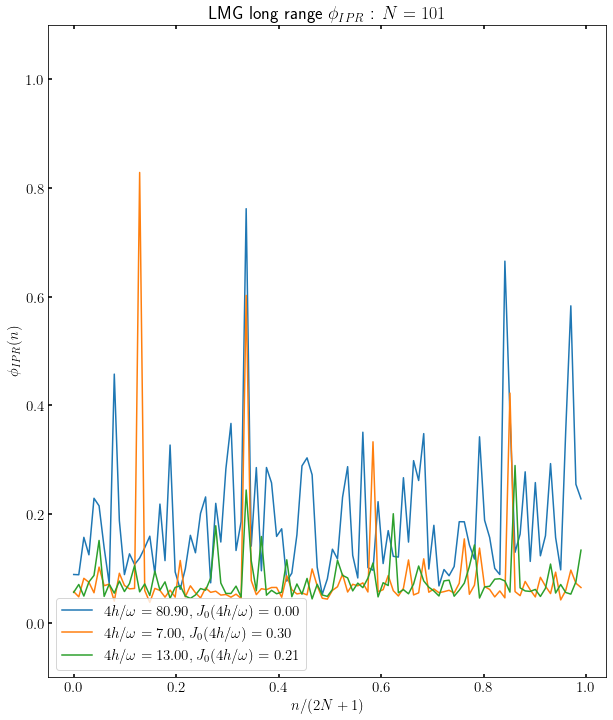

CPU times: user 5.33 s, sys: 483 ms, total: 5.82 s
Wall time: 1min 32s


In [6]:
%%time
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator, jmat, Options
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros, jn
plt.rcParams.update({
    "figure.figsize": (10, 12),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Computer Modern"]})

delta = 0.0
freezing_pts = jn_zeros(0,100)+delta

N = 50
h0 = np.sqrt(3)
omega = 2.0
nprocs = 4
w = omega
h0, h1, h2, h3 = freezing_pts[0],freezing_pts[int(N/2)], 7.0, 13.0
hs = 1/4*omega * np.array([h1, h2, h3])
etas = 4 * hs/w

p = Pool(processes = nprocs)          
print("running for 2N+1 = ", 2*N+1, "with",nprocs,"processors")  
plt.title(fr'LMG long range $ \phi_{{IPR}}$ : $N = {2*N+1}$')

p = Pool(processes = nprocs)         
#Qutip Solver Options
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)
params = [{'h0':h0, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
f_stateslist = p.map(floq_evolv,tqdm(params, position=0, leave=True))

iprmat = np.zeros((len(hs),2*N+1))
sx = jmat(N,"x")
en, st = sx.eigenstates()

for xx,h in enumerate(hs):
    f_states = f_stateslist[xx]
    iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]


#Freezing point
idx, = np.where(np.isclose(etas, h1))
n1 = idx[0]

#Intermediate IPR
idx, = np.where(np.isclose(etas, h2))
n2 = idx[0]
idx, = np.where(np.isclose(etas, h3))
n3 = idx[0]

for j, n in enumerate([n1, n2, n3]):
    xdata = np.arange(2*N+1)/(2*N+1)
    ydata =  iprmat[n]
    plt.plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")


#axs[i, 1].set_xlabel(r"$n/(2N+1)$")
#plt.yaxis.tick_right()
#plt.yaxis.set_label_position("right")
plt.ylabel(r"$\phi_{{IPR}}(n)$")
plt.ylim(-0.1, 1.1)

    

plt.xlabel(r"$n/(2N+1)$")
plt.legend(loc = 'lower left', fontsize = 15)
figname = 'comprasion_LMG_'+str(N)+'_highFr90_exact_nd_rwa.jpeg'
plt.savefig(figname, dpi = 400)
plt.show()

## Transition from Thermality to Athermality

Finally, we come to our conclusion, where we contrast the Floquet-IPR behaviour of both the periodically driven Ising model and the periodically driven LMG model. 

* For the Ising model at large $h, \omega$, we can see clear localization at freezing points, obtained by fixing $J_0(2h/\omega)=0$,  for both the exact and Rotated Wave simulations, with fairly weak delocalization away from these freezing points. 

* Since the Ising model is integrable, we can see localization even at small values of $\omega$ despite the fact that RWA breaks down and analytical treatments beyond the adiabatic limit are complicated.

* In the LMG model, we can see clear localization at localization points, obtained by fixing $J_0(4h/\omega)=0$, for both the exact and Rotated Wave simulations, with fairly weak delocalization away from those points.

* However, since the LMG model is non-integrable, and the onset of chaos in the thermodynamic limit for small $\omega$ is well-known, we can observe near complete delocalization in the IPR of the Floquet states at small $\omega$.


Thus, if we adiabatically vary $\omega, h$ in the LMG model, subjected to the constraint that $\eta=4h/\omega$ is kept at a large root of $J_0(\eta)$, there should be a crossover or phase transition from almost totally thermal to totally localized behavior. Even if we relax the constraint, there should be a macroscopic change in behaviour from thermal to athermal, although we still don't understand the detailed mechanism. This contrasts with the Ising model, where no such transition appears. Thus, the inclusion of long range interactions seems to induce a transition from thermal to localized phase, a feature that will prove useful in designing MBL engines.
